In [19]:
## All imports
import nltk
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
tqdm.pandas()
sns.set(style="darkgrid")

In [3]:
INPUT_DATA = '/scratch/harshdee/minimal_dataset.parquet'

### Loading the dataset and reading the rows, and no. for values existing for some columns

In [4]:
## Reading the dataset
citations = pd.read_parquet(INPUT_DATA)
print('Total number of rows in the minimal dataset: {}'.format(citations.count()))

Total number of rows in the minimal dataset: type_of_citation      29276667
page_title            29276667
Title                 28753918
ID_list                3928392
metadata_file           262909
updated_identifier      262909
dtype: int64


In [5]:
citations.head()

,type_of_citation,page_title,Title,ID_list,metadata_file,updated_identifier
0,citation,Television and film in New Jersey,Downtown Paterson,{ISBN=9780738563237},None,None
1,citation,The Pride of the Clan,Fort Lee Birthplace of the Motion Picture Indu...,{ISBN=0-7385-4501-5},None,None
2,citation,Gregory Avenue Bridge,History of Passaic and Its Environs. 1922. Rep...,None,None,None
3,citation,Dharma Durai,Dharma Dorai,None,None,None
4,citation,"Dingee, Victoria",Calival,None,None,None


### A few columns only exist as part of the minimal dataset:

1. `type_of_citation`: the type of the citation this identifier has.
2. `page title`: The title of the page the citation is associated with.
3. `Title`: The title of the citation
4. `ID_list`: The ID's which are associated with each citation

Then there are some other columns which are specifically related to the lookup and the new identifiers:

5. `metadata_file`: the metadata file which was queried from the CrossRef API.
6. `updated_identifier`: The identifier (DOI) which was extracted from crossref based on the title (and the author).

In [6]:
citations.columns

Index([u'type_of_citation', u'page_title', u'Title', u'ID_list',
       u'metadata_file', u'updated_identifier'],
      dtype='object')

Below we show the countplot of the top 10 citations which are present in this minimal dataset, and as we can see that `cite web` makes up for a large chunk of the citations present followed by `cite news`, `cite book`, `cite journal`.

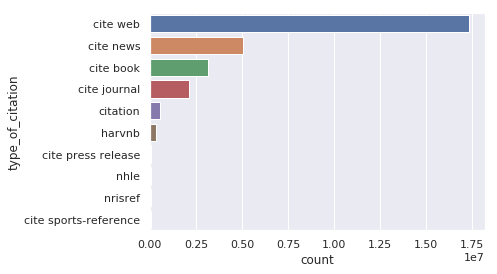

In [17]:
ax = sns.countplot(
    y="type_of_citation", data=citations,
    order=citations['type_of_citation'].value_counts().iloc[:10].index)

In the 2 cells below, we look at if there is an `ISBN` or `DOI` present in the ID_list and if it is then we group them by the `type_of_citation` to get which kind of citations have more ISBNs 

1. and as expected, ISBNs are associated more with `cite book` or `cite encyclopaedia`
2. and as expected, DOIs are associated more with `cite journal`

In [10]:
citations['contains_isbn'] = citations['ID_list'].progress_apply(
    lambda x: 'ISBN' in x if x is not None else False)
contains_isbn_mask = citations['contains_isbn'] == True
citations[contains_isbn_mask].groupby('type_of_citation').count().sort_values(
    ['contains_isbn'], ascending=False).head()

100%|██████████| 29276667/29276667 [00:35<00:00, 817661.16it/s]


,page_title,Title,ID_list,metadata_file,updated_identifier,contains_isbn
type_of_citation,,,,,,
cite book,2014465,2013791,2014465,0,0,2014465
citation,114502,114142,114502,0,0,114502
cite encyclopedia,11622,10527,11622,0,0,11622
cite journal,9383,9357,9383,0,0,9383
cite web,4080,4078,4080,0,0,4080


In [12]:
citations['contains_doi'] = citations['ID_list'].progress_apply(
    lambda x: 'DOI' in x if x is not None else False)
contains_doi_mask = citations['contains_doi'] == True
citations[contains_doi_mask].groupby('type_of_citation').count().sort_values(
    ['contains_doi'], ascending=False).head()

100%|██████████| 29276667/29276667 [00:36<00:00, 805364.16it/s]


,page_title,Title,ID_list,metadata_file,updated_identifier,contains_isbn,contains_doi
type_of_citation,,,,,,,
cite journal,1355483,1354869,1355483,0,0,1355483,1355483
citation,41881,40756,41881,0,0,41881,41881
cite book,31834,31794,31834,0,0,31834,31834
cite web,6744,6743,6744,0,0,6744,6744
cite encyclopedia,2512,2126,2512,0,0,2512,2512


Something cool now..

We take all the words which make up the `Page titles`, tokenize them, remove the stop words and calculate the frequency for each of the words which were present in making those titles.

and we see that 5 most used words in titles are: `list`, `season`, `football`, `united`, `film` (which goes with the above histogram of the tpye of citations where we found out that web material is more present as citations on Wikipedia)

In [44]:
## Make all words uniform by doing them into lowercase and removing the stopwords.
all_words = citations['page_title'].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')

In [45]:
words = nltk.tokenize.word_tokenize(all_words)
words = [word for word in words if word.isalnum()]
word_dist = nltk.FreqDist(words)

In [46]:
## Get rid of all the stopwords
stopwords = nltk.corpus.stopwords.words('english')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 

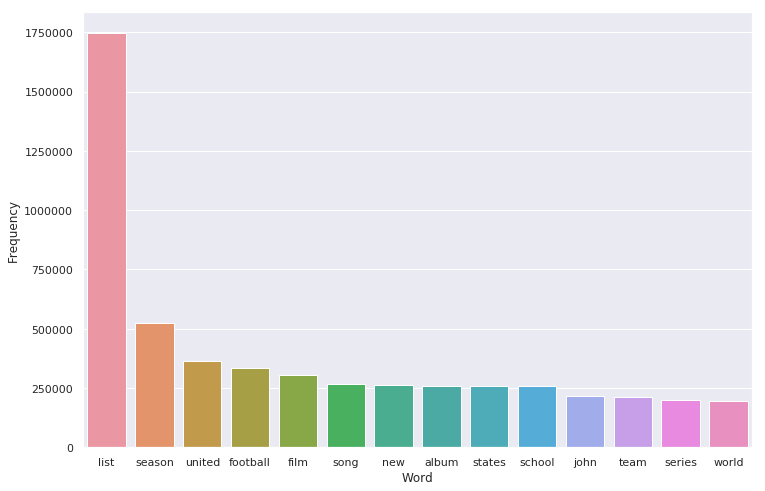

In [47]:
## Graph them based on the frequency
resultant_freq_words = pd.DataFrame(words_except_stop_dist.most_common(14),
                    columns=['Word', 'Frequency'])
sns.set(rc={'figure.figsize':(12, 8)})
ax = sns.barplot(x="Word", y="Frequency", data=resultant_freq_words)

Now, we try to make a Graph, out of the page titles which have an associated new identifier with them from CrossRef, this can be done using `networkx` library.

This is basically a graph of nodes where nodes can either be the `page_title` or a specific DOI, and now we are checking for the a page_title with the most identifier and we query one of them -- `List of dolichopodid genera` which is page related to the biological domain.

We see that most of the articles are either related to the biological domain or related to the biobliography of the countries.

We also look that most of the page title have either 1, 2 or 3 new identifiers associated with them from CrossRef.

In [30]:
citations_with_updated_identifier = citations[citations['updated_identifier'].notnull()]

In [52]:
page_titles_with_identfier = citations_with_updated_identifier.groupby(['page_title'])['updated_identifier'].apply(list)
page_titles_with_identfier = page_titles_with_identfier.reset_index()

In [65]:
page_titles_with_identfier['updated_identifier'] = page_titles_with_identfier['updated_identifier'].progress_apply(
    lambda x: np.concatenate(np.array(x)).ravel().tolist())

In [66]:
## Convert it into a dictionary so that we can feed it into the networkx graph
zipped_titles_with_ids = dict(zip(
    page_titles_with_identfier['page_title'],
    page_titles_with_identfier['updated_identifier']))

In [67]:
g = nx.Graph(zipped_titles_with_ids)

In [73]:
## Get the top to titles by the degree they are associated with basically the DOIs for each of their citations
all_titles_with_degrees = [(i,j) for i, j in sorted(g.degree, key=lambda x: x[1]) if not i.startswith('10.')]
sorted(all_titles_with_degrees, key=lambda x: x[1], reverse=True)[:10]

[(u'Bibliography of the Russian Revolution and Civil War', 156),
 (u'Bibliography of the Post Stalinist Soviet Union', 155),
 (u'List of dolichopodid genera', 144),
 (u'2014 in arthropod paleontology', 134),
 (u'List of gastropods described in 2016', 133),
 (u'2012 in arthropod paleontology', 126),
 (u'List of Eumolpinae genera', 116),
 (u'List of gastropods described in 2017', 108),
 (u'Red-tailed hawk', 101),
 (u'List of gastropods described in the 2000s', 100)]

In [70]:
## As we can some of these citations did not have anything in the ID_list but we populate them with identifiers
citations_with_updated_identifier[
    citations_with_updated_identifier['page_title'] == 'List of dolichopodid genera'].tail()

,type_of_citation,page_title,Title,ID_list,metadata_file,updated_identifier
27286803,cite journal,List of dolichopodid genera,Generic name changes in Diptera,None,_760423.json,[10.1111/j.1365-3113.1945.tb00021.x]
27433966,cite journal,List of dolichopodid genera,Two new genera of parathalassiine-Iike flies f...,None,_250016.json,[10.5733/afin.054.0103]
27869636,cite journal,List of dolichopodid genera,"Ethiromyia, a new genus of Holarctic Dolichopo...",None,_206517.json,"[10.11646/zootaxa.857.1.1, 10.11646/zootaxa.36..."
28161385,cite journal,List of dolichopodid genera,\xc4gyptische dipteren,None,_760422.json,[10.5962/bhl.title.9277]
28307663,cite journal,List of dolichopodid genera,Etudes sur les Dolichopodides,None,_732235.json,[10.1080/00222933408654790]


In [72]:
## Most of the page titles have either 1, 2 or 3 new identifiers
Counter([j for _, j in sorted(all_titles_with_degrees, key=lambda x: x[1], reverse=True)]).most_common(10)

[(3, 64042),
 (1, 46339),
 (2, 21372),
 (4, 8299),
 (6, 7875),
 (5, 5100),
 (7, 2465),
 (9, 1958),
 (8, 1694),
 (10, 1055)]